<a href="https://colab.research.google.com/github/zahrael97/COVID-19-detection-using-deep-Learning/blob/master/InceptionV3/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pneumonia Detection using Transfer Learning**

In [1]:
# importing all the required libraries and modules

import numpy as np
import os, random
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Path of various directories
# Dataset : Chest X-Ray Images (Pneumonia) from Kaggle 

TRAIN_DIR = '/content/drive/My Drive/Dataset_Zahra/train'
TEST_DIR = '/content/drive/My Drive/Dataset_Zahra/test'
#VAL_DIR = '/content/drive/My Drive/chest_xray/val'

Covid_train = '/content/drive/My Drive/chest_xray/train/Covid'
normal_train = '/content/drive/My Drive/chest_xray/train/normal'

Covid_test = '/content/drive/My Drive/chest_xray/test/Covid'
normal_test = '/content/drive/My Drive/chest_xray/test/normal'

#pneumonia_val = '/content/drive/My Drive/chest_xray/val/PNEUMONIA'
#normal_val = '/content/drive/My Drive/chest_xray/val/NORMAL'

# **Customizing the Inceptionv3 model**

In [4]:
base_model=InceptionV3(weights='imagenet',include_top=False, input_shape=(224,224,3)) #imports the inceptionv3 model 
# and slices off the top layer which is the one that classifies objects into various classes (we don't want this layer)

# Setting up the pre-trained weights of the inceptionv3 model as non-trainable
for layer in base_model.layers:
    layer.trainable=False       

# Adding new layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation - here, we have only 2 classes (Pneumonia & Normal)

87916544/87910968 [==============================] - 8s 0us/step


In [5]:
# Specify the inputs
# Specify the outputs
model=Model(inputs=base_model.inputs,outputs=preds)

# A new model has been created based on our architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [6]:
# Name of all the layers in our new model which is built on top of the Inceptionv3 model (look at No. 311 till final layer)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

## **Data Preparation**

In [7]:
def dir_file_count(directory):
  #Total number of files present inside the 'directory'
  return sum([len(files) for r, d, files in os.walk(directory)])

# Configuration parameters 
rescale = 1./255
target_size = (224, 224)
batch_size = 32            #Specifying the batch size
class_mode = 'categorical'

# Augment the training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
#val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
#val_generator = val_datagen.flow_from_directory(VAL_DIR, 
#                                                target_size=target_size,
#                                                class_mode=class_mode,
#                                                batch_size=dir_file_count(VAL_DIR),
#                                                shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(TEST_DIR),
                                                  shuffle=False)

Found 304 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


# **Training Process of our custom model**

In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Loss function will be categorical cross entropy
# Evaluation metric will be accuracy

# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=25,                                # Specifying the no. of epochs
                              validation_data=test_generator,
                              validation_steps=len(test_generator)
                            )

Epoch 1/25
10/10 [==============================] - 21s 2s/step - loss: 0.8679 - accuracy: 0.7533 - val_loss: 0.9975 - val_accuracy: 0.4952
Epoch 2/25
10/10 [==============================] - 11s 1s/step - loss: 0.3303 - accuracy: 0.8816 - val_loss: 1.3844 - val_accuracy: 0.6095
Epoch 3/25
10/10 [==============================] - 14s 1s/step - loss: 0.1943 - accuracy: 0.9342 - val_loss: 0.2636 - val_accuracy: 0.9429
Epoch 4/25
10/10 [==============================] - 14s 1s/step - loss: 0.1867 - accuracy: 0.9441 - val_loss: 2.9874 - val_accuracy: 0.4571
Epoch 5/25
10/10 [==============================] - 14s 1s/step - loss: 0.2297 - accuracy: 0.9079 - val_loss: 0.3489 - val_accuracy: 0.9143
Epoch 6/25
10/10 [==============================] - 14s 1s/step - loss: 0.1731 - accuracy: 0.9342 - val_loss: 0.2668 - val_accuracy: 0.9429
Epoch 7/25
10/10 [==============================] - 14s 1s/step - loss: 0.2022 - accuracy: 0.9243 - val_loss: 0.2108 - val_accuracy: 0.9429
Epoch 8/25
10/10 [==

# **Evaluation metrics (Performance)**

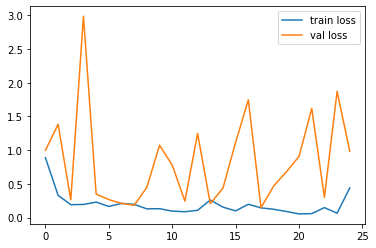

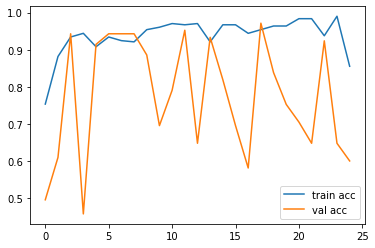

<Figure size 432x288 with 0 Axes>

In [10]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('IncenptionV3.h5')

In [11]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*70)
print("Report")
print("-"*70)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*70)
print("\n\n")

cls_report_print = classification_report(y_true, y_pred, target_names=['covid', 'Normal'])

cls_report = classification_report(y_true, y_pred, target_names=['covid', 'Normal'], output_dict=True)

print("-"*70)
print("covid Prediction")
print("-"*70)
print(cls_report_print)
print("-"*70)

1/1 [==============================] - 6s 6s/step
----------------------------------------------------------------------
Report
----------------------------------------------------------------------
Precision     : 50.59%
Recall        : 100.00%
F1-Score      : 67.19%
----------------------------------------------------------------------



----------------------------------------------------------------------
covid Prediction
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       1.00      0.32      0.49        62
      Normal       0.51      1.00      0.67        43

    accuracy                           0.60       105
   macro avg       0.75      0.66      0.58       105
weighted avg       0.80      0.60      0.56       105

----------------------------------------------------------------------
